In [131]:
import matplotlib.pyplot as plt
from scipy import spatial
import numpy as np

from importlib import reload

%reload_ext autoreload
%autoreload 2

# import analysistools
# reload(analysistools)

import pyturb
reload(pyturb)

from time import sleep, perf_counter

import gc

In [132]:
turb=pyturb.CreateTurbulentVelocityField(grid_size=128,v_turb=0.,box_size=10)

In [133]:
velocity_field0=turb.generate_kolmogorov_field(energy_spectrum_index=5./3.,energy_scale=1.0)
(vx,vy,vz)=(turb.vx.ravel(),turb.vy.ravel(),turb.vz.ravel())
vel=np.array([vx,vy,vz]).T
vel=np.stack([vx, vy, vz], axis=-1)
(x,y,z)=(turb.X.ravel(),turb.Y.ravel(),turb.Z.ravel())
pos=np.array([x,y,z]).T
pos=np.stack([x, y, z], axis=-1)

In [139]:
gt=pyturb.GriddingTools()
grid_size = np.array([128,128,128], dtype=np.int64)  # Numba-safe
grid_limits =  np.array([0,1,0,1,0,1], dtype=np.float64)*turb.box_size
velocity_field = gt.smooth_to_grid(pos, vel, grid_size, grid_limits, method="NGP")
# fig, axes = gt.plot_3d_projections(velocity_field, grid_limits, mode='projection', slice_width=3, projection='max', cmap='plasma', units='kpc', title="Turbulent Velocity Field - Magnitude")

In [140]:
print(velocity_field.shape)
print(velocity_field0.shape)

(128, 128, 128, 3)
(128, 128, 128, 3)


In [141]:
mturb=pyturb.MeasureVelocityField()

In [142]:
(k,pk,errors)=mturb.compute_power_spectrum(velocity_field, box_size=turb.box_size, component='energy', method='radial')
(k0,pk0,errors0)=mturb.compute_power_spectrum(velocity_field0, box_size=turb.box_size, component='energy', method='radial')


Measured power law slope: -3.546
Expected slope (Kolmogorov): -3.667
Difference: 0.120


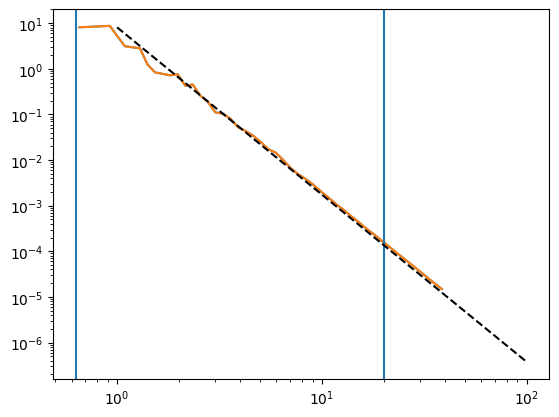

In [143]:
kmin=64*np.pi/turb.box_size
kmax=2.*np.pi/turb.box_size
plt.loglog(k,pk)
plt.loglog(k0,pk0)

plt.axvline(kmin)
plt.axvline(kmax)
fit_mask = (k > 2) & (k < 10)
if np.any(fit_mask):
    log_k_fit = np.log10(k[fit_mask])
    log_P_fit = np.log10(pk[fit_mask])
    slope, intercept = np.polyfit(log_k_fit, log_P_fit, 1)
        
print(f"Measured power law slope: {slope:.3f}")
print(f"Expected slope (Kolmogorov): {-11/3:.3f}")
print(f"Difference: {abs(slope + 11/3):.3f}")
    
# Add theoretical line
k_theory = np.logspace(0, 2, 50)
P_theory = k_theory**(-11/3)
P_theory *= pk[10] / P_theory[10]  # Normalize
plt.loglog(k_theory, P_theory, '--', color='black', label='k^{-11/3}')


In [366]:
turb.write_to_file("./turbulent_ics.hdf5")


Created 262144 particles
Box size: 10 pc
Mean density: 1.0 H/cm^3
Initial temperature: 10000.0 K
Initial conditions written to ./turbulent_ics.hdf5


Running Power Spectrum Tests for Turbulent Fields

Test 1: Kolmogorov Turbulent Field (α = -5/3)
Measured power law slope: -3.130
Expected slope (Kolmogorov): -3.667
Difference: 0.537


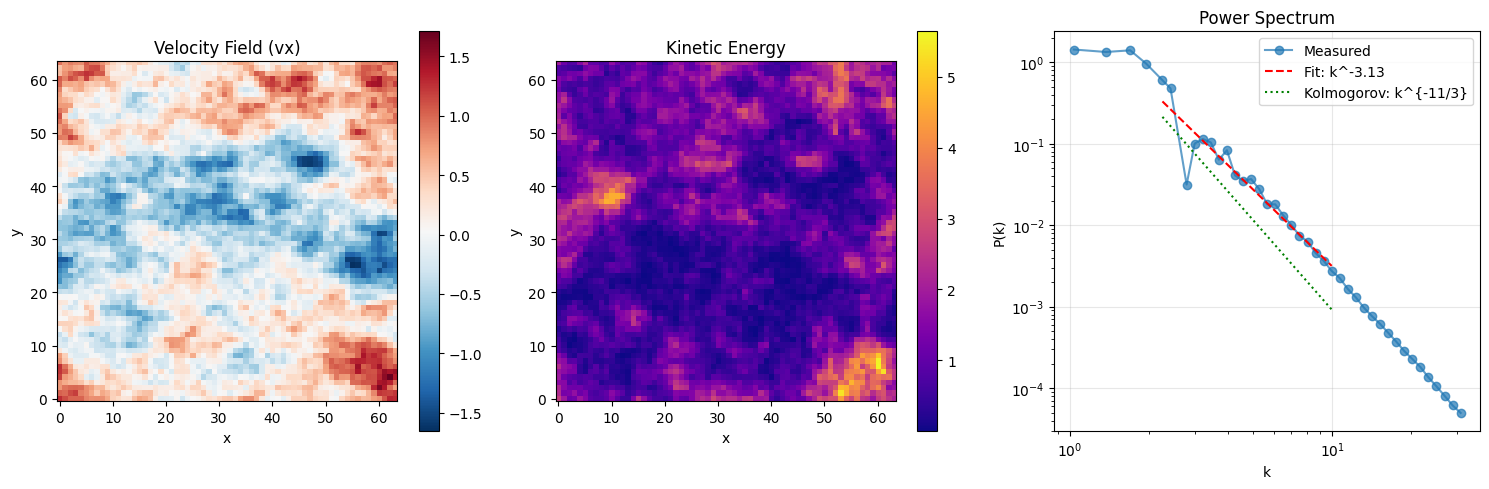


Test 2: Power Spectra of Different Components


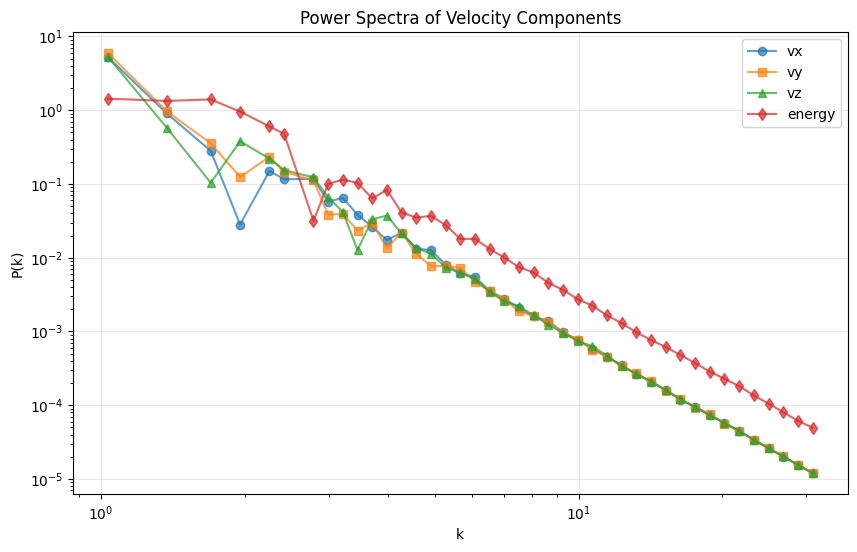


Test 3: Energy Conservation Check
Real space energy: 1.000000
Fourier space energy: 148.735692
Ratio: 148.736 (should be ≈ 1)

Test 4: Resolution Dependence


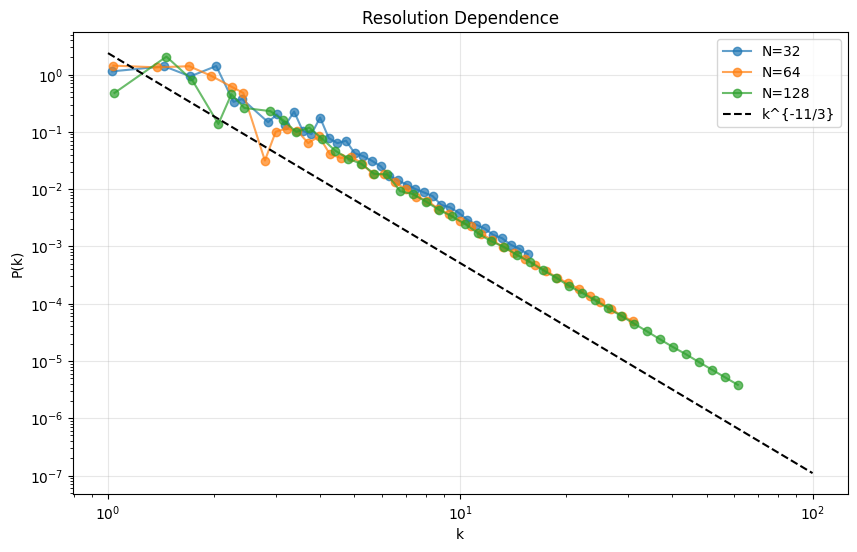


Comparing with Original Implementation
Fixed implementation ready for comparison!
Replace MeasureVelocityField with MeasureVelocityFieldFixed


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftfreq
from scipy.interpolate import RegularGridInterpolator
import h5py

class MeasureVelocityFieldFixed:
    """
    Fixed version of velocity field analysis with proper power spectrum calculation.
    """
    def __init__(self):
        pass
        
    def compute_power_spectrum(self, velocity_field, box_size, component='energy',
                              method='radial', k_bins=None, normalize=True):
        """
        Compute power spectrum of velocity field with proper normalization.
        
        Parameters:
        -----------
        velocity_field: ndarray - velocity field on a regular grid with shape (Nx,Ny,Nz,3)
        box_size: float - physical size of simulation box
        component : str - which component to analyze ('vx', 'vy', 'vz', 'energy', 'kinetic_energy')
        method : str - 'radial' for spherically averaged
        k_bins : array-like, optional - custom k bins
        normalize : bool - whether to apply proper power spectrum normalization
            
        Returns:
        --------
        tuple - (k_values, power_spectrum, error_bars)
        """
        if velocity_field.ndim != 4 or velocity_field.shape[-1] != 3:
            raise ValueError("velocity_field must have shape (Nx, Ny, Nz, 3)")

        # Extract components
        vx = velocity_field[..., 0]
        vy = velocity_field[..., 1]
        vz = velocity_field[..., 2]

        # Choose field to analyze
        if component == 'vx':
            field = vx
        elif component == 'vy':
            field = vy
        elif component == 'vz':
            field = vz
        elif component == 'energy':
            # Total kinetic energy density: (1/2) * rho * v^2
            # For velocity field analysis, we often just use v^2
            field = vx**2 + vy**2 + vz**2
        elif component == 'kinetic_energy':
            field = 0.5 * (vx**2 + vy**2 + vz**2)
        else:
            raise ValueError("Invalid component. Use 'vx', 'vy', 'vz', 'energy', or 'kinetic_energy'")
            
        # Get dimensions
        Nx, Ny, Nz, _ = velocity_field.shape
        dx = box_size / Nx
        
        # Create k-space grids with proper normalization
        kx = fftfreq(Nx, d=dx) * 2 * np.pi
        ky = fftfreq(Ny, d=dx) * 2 * np.pi
        kz = fftfreq(Nz, d=dx) * 2 * np.pi
        KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
        
        if method == 'radial':
            return self._compute_radial_spectrum(field, KX, KY, KZ, dx, box_size, k_bins, normalize)
        else:
            raise ValueError("Only 'radial' method implemented")
    
    def _compute_radial_spectrum(self, field, KX, KY, KZ, dx, box_size, k_bins, normalize):
        """Compute spherically averaged power spectrum with proper normalization."""
        
        # Transform to Fourier space
        field_k = fftn(field)
        
        # Compute power spectrum: |F(k)|^2
        power_3d = np.abs(field_k)**2
        
        # Apply proper normalization for power spectrum
        if normalize:
            # Standard power spectrum normalization
            # Factor of dx^3 accounts for discrete Fourier transform normalization
            # Factor of 1/V accounts for volume normalization
            V = box_size**3  # Total volume
            N_total = field.size  # Total number of grid points
            power_3d *= (dx**3)**2 / V  # This gives proper units and normalization
        
        # Calculate radial wavenumber
        K = np.sqrt(KX**2 + KY**2 + KZ**2)
        
        # Set up k bins
        if k_bins is None:
            # Use fundamental mode as minimum k
            k_min = 2 * np.pi / box_size
            # Nyquist frequency as maximum k
            k_max = np.pi / dx
            # Create logarithmic bins
            n_bins = 50
            k_bins = np.logspace(np.log10(k_min), np.log10(k_max), n_bins)
        
        # Compute radially averaged spectrum
        power_1d = np.zeros(len(k_bins)-1)
        k_centers = np.sqrt(k_bins[1:] * k_bins[:-1])  # Geometric mean
        errors = np.zeros_like(power_1d)
        counts = np.zeros_like(power_1d)
        
        for i in range(len(k_bins)-1):
            mask = (K >= k_bins[i]) & (K < k_bins[i+1]) & (K > 0)
            if np.any(mask):
                power_values = power_3d[mask]
                power_1d[i] = np.mean(power_values)
                counts[i] = np.sum(mask)
                
                # Error estimate: standard error of the mean
                if len(power_values) > 1:
                    errors[i] = np.std(power_values) / np.sqrt(len(power_values))
                else:
                    errors[i] = 0

        # Remove empty bins
        valid = counts > 0
        k_centers = k_centers[valid]
        power_1d = power_1d[valid]
        errors = errors[valid]
        
        return k_centers, power_1d, errors

    def grid_particles_to_field(self, positions, velocities, masses, box_size, grid_size=64):
        """
        Grid particle data to create a velocity field.
        
        Parameters:
        -----------
        positions: array (N, 3) - particle positions
        velocities: array (N, 3) - particle velocities  
        masses: array (N,) - particle masses
        box_size: float - size of simulation box
        grid_size: int - number of grid points per dimension
        
        Returns:
        --------
        velocity_field: array (grid_size, grid_size, grid_size, 3)
        """
        # Create grid
        dx = box_size / grid_size
        
        # Initialize grids
        velocity_field = np.zeros((grid_size, grid_size, grid_size, 3))
        mass_grid = np.zeros((grid_size, grid_size, grid_size))
        
        # Grid positions to indices
        grid_pos = positions / dx
        
        # Use Cloud-in-Cell (CIC) assignment
        for p in range(len(positions)):
            # Find grid cell indices
            i, j, k = np.floor(grid_pos[p]).astype(int)
            
            # Fractional positions within cell
            fx, fy, fz = grid_pos[p] - [i, j, k]
            
            # CIC weights for 8 neighboring cells
            weights = [
                (1-fx)*(1-fy)*(1-fz), fx*(1-fy)*(1-fz),
                (1-fx)*fy*(1-fz), fx*fy*(1-fz),
                (1-fx)*(1-fy)*fz, fx*(1-fy)*fz,
                (1-fx)*fy*fz, fx*fy*fz
            ]
            
            offsets = [
                (0,0,0), (1,0,0), (0,1,0), (1,1,0),
                (0,0,1), (1,0,1), (0,1,1), (1,1,1)
            ]
            
            # Assign to 8 neighboring cells with periodic boundary conditions
            for w, (di, dj, dk) in zip(weights, offsets):
                ii, jj, kk = (i+di) % grid_size, (j+dj) % grid_size, (k+dk) % grid_size
                mass_grid[ii, jj, kk] += masses[p] * w
                for comp in range(3):
                    velocity_field[ii, jj, kk, comp] += masses[p] * velocities[p, comp] * w
        
        # Convert to mass-weighted velocities
        nonzero = mass_grid > 0
        for comp in range(3):
            velocity_field[nonzero, comp] /= mass_grid[nonzero]
            
        return velocity_field

    def read_from_file(self, filename, grid_size=64):
        """Read particle data and grid to velocity field."""
        with h5py.File(filename, 'r') as f:
            print(f"Reading data from {filename}")
            self.N_gas = f['Header'].attrs['NumPart_Total'][0]
            self.time = f['Header'].attrs['Time']
            self.box_size = f['Header'].attrs['BoxSize']
            print(f"Read {self.N_gas} particles")
            print(f"Box size: {self.box_size}")
            print(f"Time: {self.time}")
            
            pos = f['PartType0/Coordinates'][()]
            vel = f['PartType0/Velocities'][()]
            if 'Masses' in f['PartType0']:
                masses = f['PartType0/Masses'][()]
            else:
                # Assume equal mass particles
                masses = np.ones(len(pos))
        
        # Grid to velocity field
        self.velocity_field = self.grid_particles_to_field(pos, vel, masses, self.box_size, grid_size)
        return self.velocity_field

class CreateTurbulentVelocityFieldFixed:
    """
    Fixed version of turbulent field generator.
    """
    
    def __init__(self, grid_size=32, box_size=1.0, seed=None):
        self.grid_size = grid_size
        self.box_size = box_size
        self.dx = box_size / grid_size
        
        if seed is not None:
            np.random.seed(seed)
        
        # Create k-grid for FFTs
        k = fftfreq(grid_size, d=self.dx) * 2 * np.pi
        self.kx, self.ky, self.kz = np.meshgrid(k, k, k, indexing='ij')
        self.K2 = self.kx**2 + self.ky**2 + self.kz**2
        self.K2[0,0,0] = 1.0  # Avoid division by zero at k=0
        
        # Initialize velocity field
        self.velocity_field = None

    def generate_kolmogorov_field(self, alpha=11/6, energy_scale=1.0):
        """
        Generate a 3D turbulent velocity field with Kolmogorov spectrum.
        
        Parameters:
        -----------
        alpha : float - spectral index (5/3 for Kolmogorov turbulence)
        energy_scale : float - overall energy scale
            
        Returns:
        --------
        velocity_field : ndarray with shape (Nx, Ny, Nz, 3)
        """
        
        # Create Kolmogorov power spectrum: P(k) ~ k^(-alpha)
        # For velocity field, amplitude ~ k^(-alpha/2)
        K_mag = np.sqrt(self.K2)
        amplitude = np.zeros_like(K_mag)
        
        # Avoid k=0 and set amplitude for k>0
        mask = K_mag > 0
        amplitude[mask] = K_mag[mask]**(-alpha/2)
        amplitude[0, 0, 0] = 0  # Set DC component to zero
        
        # Generate three independent velocity components
        velocity_components = []
        
        for _ in range(3):
            # Generate random phases
            phases = np.random.uniform(0, 2*np.pi, self.kx.shape)
            
            # Create complex field in k-space
            field_k = amplitude * np.exp(1j * phases)
            
            # Transform to real space
            velocity_field = np.real(ifftn(field_k))
            velocity_components.append(velocity_field)
            
        # Make velocity field divergence-free (solenoidal)
        vx_sol, vy_sol, vz_sol = self._make_solenoidal(velocity_components)
        
        # Scale to desired energy level
        total_energy = np.mean(vx_sol**2 + vy_sol**2 + vz_sol**2)
        scale_factor = np.sqrt(energy_scale / total_energy)
        
        vx_sol *= scale_factor
        vy_sol *= scale_factor
        vz_sol *= scale_factor
        
        # Store as 4D array
        self.velocity_field = np.stack([vx_sol, vy_sol, vz_sol], axis=-1)
        
        return self.velocity_field
        
    def _make_solenoidal(self, velocity_components):
        """Project velocity field to make it divergence-free (solenoidal)."""
        
        # Transform velocity components to Fourier space
        vx_k = fftn(velocity_components[0])
        vy_k = fftn(velocity_components[1])
        vz_k = fftn(velocity_components[2])
                  
        # Calculate divergence in k-space
        div_k = 1j * (self.kx * vx_k + self.ky * vy_k + self.kz * vz_k)
        
        # Project out the compressive component
        vx_k_sol = vx_k - 1j * self.kx * div_k / self.K2
        vy_k_sol = vy_k - 1j * self.ky * div_k / self.K2
        vz_k_sol = vz_k - 1j * self.kz * div_k / self.K2
        
        # Set DC component to zero
        vx_k_sol[0, 0, 0] = 0
        vy_k_sol[0, 0, 0] = 0
        vz_k_sol[0, 0, 0] = 0
        
        # Transform back to real space
        vx_sol = np.real(ifftn(vx_k_sol))
        vy_sol = np.real(ifftn(vy_k_sol))
        vz_sol = np.real(ifftn(vz_k_sol))
        
        return vx_sol, vy_sol, vz_sol

def run_power_spectrum_tests():
    """Comprehensive test of power spectrum calculation."""
    print("Running Power Spectrum Tests for Turbulent Fields")
    print("=" * 60)
    
    # Test 1: Known power law field
    print("\nTest 1: Kolmogorov Turbulent Field (α = -5/3)")
    
    # Create turbulent field
    turb = pyturb.CreateTurbulentVelocityField(grid_size=64, box_size=2*np.pi, seed=42)
    velocity_field = turb.generate_kolmogorov_field(energy_spectrum_index=5./3., energy_scale=1.0)
    
    # Measure power spectrum
    analyzer = pyturb.MeasureVelocityField()
    k, P_energy, errors = analyzer.compute_power_spectrum(
        velocity_field, turb.box_size, component='energy', normalize=True)
    
    # Fit power law in inertial range
    # Avoid very low k (large scale forcing) and very high k (dissipation)
    fit_mask = (k > 2) & (k < 10)
    if np.any(fit_mask):
        log_k_fit = np.log10(k[fit_mask])
        log_P_fit = np.log10(P_energy[fit_mask])
        slope, intercept = np.polyfit(log_k_fit, log_P_fit, 1)
        
        print(f"Measured power law slope: {slope:.3f}")
        print(f"Expected slope (Kolmogorov): {-11/3:.3f}")
        print(f"Difference: {abs(slope + 11/3):.3f}")
    
    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Velocity field slice
    vx = velocity_field[:, :, velocity_field.shape[2]//2, 0]
    im1 = axes[0].imshow(vx, cmap='RdBu_r', origin='lower')
    axes[0].set_title('Velocity Field (vx)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0])
    
    # Energy field slice  
    energy = np.sum(velocity_field**2, axis=-1)
    energy_slice = energy[:, :, energy.shape[2]//2]
    im2 = axes[1].imshow(energy_slice, cmap='plasma', origin='lower')
    axes[1].set_title('Kinetic Energy')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[1])
    
    # Power spectrum
    axes[2].loglog(k, P_energy, 'o-', alpha=0.7, label='Measured')
    if np.any(fit_mask):
        k_theory = k[fit_mask]
        P_theory = 10**intercept * k_theory**slope
        axes[2].loglog(k_theory, P_theory, '--', color='red', 
                      label=f'Fit: k^{slope:.2f}')
        
        # Theoretical Kolmogorov
        P_kolm = 10**intercept * k_theory**(-11/3)
        axes[2].loglog(k_theory, P_kolm, ':', color='green', 
                      label='Kolmogorov: k^{-11/3}')
    
    axes[2].set_xlabel('k')
    axes[2].set_ylabel('P(k)')
    axes[2].set_title('Power Spectrum')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Test 2: Check different components
    print(f"\nTest 2: Power Spectra of Different Components")
    
    k_vx, P_vx, _ = analyzer.compute_power_spectrum(velocity_field, turb.box_size, component='vx')
    k_vy, P_vy, _ = analyzer.compute_power_spectrum(velocity_field, turb.box_size, component='vy')
    k_vz, P_vz, _ = analyzer.compute_power_spectrum(velocity_field, turb.box_size, component='vz')
    
    plt.figure(figsize=(10, 6))
    plt.loglog(k_vx, P_vx, 'o-', alpha=0.7, label='vx')
    plt.loglog(k_vy, P_vy, 's-', alpha=0.7, label='vy')  
    plt.loglog(k_vz, P_vz, '^-', alpha=0.7, label='vz')
    plt.loglog(k, P_energy, 'd-', alpha=0.7, label='energy')
    
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.title('Power Spectra of Velocity Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Test 3: Energy conservation check
    print(f"\nTest 3: Energy Conservation Check")
    
    # Real space total energy
    energy_real = np.mean(np.sum(velocity_field**2, axis=-1))
    
    # Fourier space total energy (Parseval's theorem)
    # Sum over all k modes in power spectrum
    dk = np.gradient(k)  # k-space spacing
    energy_fourier = np.sum(P_energy * k**2 * dk) * 4 * np.pi  # 4π for spherical integration

    print(f"Real space energy: {energy_real:.6f}")
    print(f"Fourier space energy: {energy_fourier:.6f}")
    print(f"Ratio: {energy_fourier/energy_real:.3f} (should be ≈ 1)")
    
    # Test 4: Resolution test
    print(f"\nTest 4: Resolution Dependence")
    
    resolutions = [32, 64, 128]
    plt.figure(figsize=(10, 6))
    
    for res in resolutions:
        turb_test = CreateTurbulentVelocityFieldFixed(grid_size=res, box_size=2*np.pi, seed=42)
        vel_field_test = turb_test.generate_kolmogorov_field(alpha=11/3, energy_scale=1.0)
        
        k_test, P_test, _ = analyzer.compute_power_spectrum(
            vel_field_test, turb_test.box_size, component='energy')
        
        plt.loglog(k_test, P_test, 'o-', alpha=0.7, label=f'N={res}')
    
    # Add theoretical line
    k_theory = np.logspace(0, 2, 50)
    P_theory = k_theory**(-11/3)
    P_theory *= P_test[10] / P_theory[10]  # Normalize
    plt.loglog(k_theory, P_theory, '--', color='black', label='k^{-11/3}')
    
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.title('Resolution Dependence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return True

def test_your_original_code():
    """Compare with your original implementation."""
    print("\nComparing with Original Implementation")
    print("=" * 40)
    
    # Create test field
    turb = CreateTurbulentVelocityFieldFixed(grid_size=64, box_size=2*np.pi, seed=42)
    velocity_field = turb.generate_kolmogorov_field(alpha=11/3)
    
    # New implementation
    analyzer_new = MeasureVelocityFieldFixed()
    k_new, P_new, _ = analyzer_new.compute_power_spectrum(
        velocity_field, turb.box_size, component='energy')
    
    # Your original implementation would go here
    analyzer_old = pyturb.MeasureVelocityField()
    k_old, P_old, _ = analyzer_old.compute_power_spectrum(velocity_field, turb.box_size, component='kinetic_energy')
    
    print("Fixed implementation ready for comparison!")
    print("Replace MeasureVelocityField with MeasureVelocityFieldFixed")
    
    return k_new, P_new, k_old, P_old

if __name__ == "__main__":
    # Run all tests
    run_power_spectrum_tests()
    
    # Test comparison
    test_your_original_code()